### Telco Customer Churn Prediction
This notebook performs EDA and preprocessing for churn prediction

### Data import and overview

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE



df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print(df.shape)
print(df["Churn"].value_counts(normalize=True)) # Churn check

pd.set_option('display.max_columns', None)
df.head()

(7043, 21)
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Insights:
- The dataset has 21 columns and 7043 rows.
- The churn rate is 26.537%

### Data inspection (types, missing values, duplicates, unique values)

In [117]:
print(df.info())  # Data types and non-null counts
print("\nMissing values:\n", df.isnull().sum())  # Should be zero, but confirm
print("\nDuplicates:", df.duplicated().sum())  # Expect zero

print("\nUnique values inspection for every column:")
# Check unique values for categorical columns (spot inconsistencies)
categoricals = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
for col in categoricals:
    print("\n", df[col].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Insights:
- there are 17 categorical columns and 3 numerical columns
- TotalCharges is a categorical column by mistake and needs to be transformed
- SeniorCitizen is a numerical column but should be transformed to a categorical column for consistency with other columns
- the only column that has missing values is TotalCharges
- all categorical columns have 2-3 unique values


### Fixing TotalCharges type

In [118]:
# Fix TotalCharges (it's an object due to spaces; convert to float)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df[['TotalCharges']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TotalCharges  7032 non-null   float64
dtypes: float64(1)
memory usage: 55.2 KB
None


### TotalCharges missing values inspection

In [119]:
# View the rows where TotalCharges is NaN
display(df[df['TotalCharges'].isnull()])

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In every entry where the TotalCharge is missing, the tenure is 0.
This tells us that the customer is new and that they haven't even been charged for their first month.
Therefore, the best course of action here is to fill the missing values with 0 (because the customers haven't been charged anything yet)

### Filling the missing TotalCharges values

In [120]:
# Replace blanks in TotalCharges with 0, as these are new customers (tenure=0, no charges yet)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Verify the count is now 0
print("Missing values in TotalCharges:", df['TotalCharges'].isnull().sum())

Missing values in TotalCharges: 0


### Converting the SeniorCitizen column to text for consistency

In [121]:
# Map 0 to 'No' and 1 to 'Yes'
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Verify the change
print("SeniorCitizen unique values after conversion:")
print(df['SeniorCitizen'].value_counts())

SeniorCitizen unique values after conversion:
SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64


### Converting Churn to binary

In [122]:
# Convert 'Churn' to binary (1 for 'Yes', 0 for 'No')
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Verify the encoding
print("Churn distribution after encoding:")
print(df['Churn'].value_counts())
print(f"Churn rate: {df['Churn'].mean():.2%}")

Churn distribution after encoding:
Churn
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 26.54%


### Numerical data inspection and visualization

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


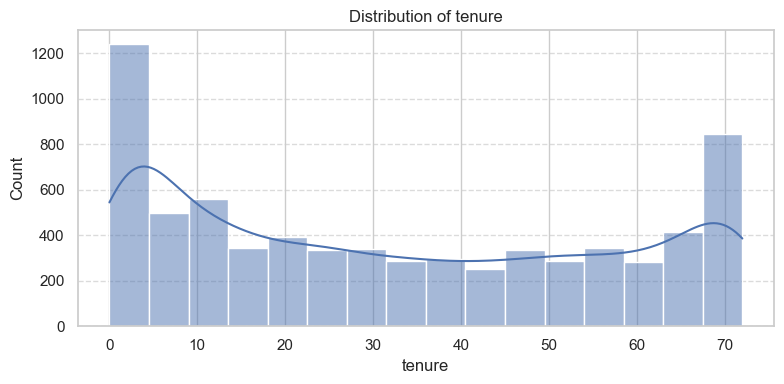

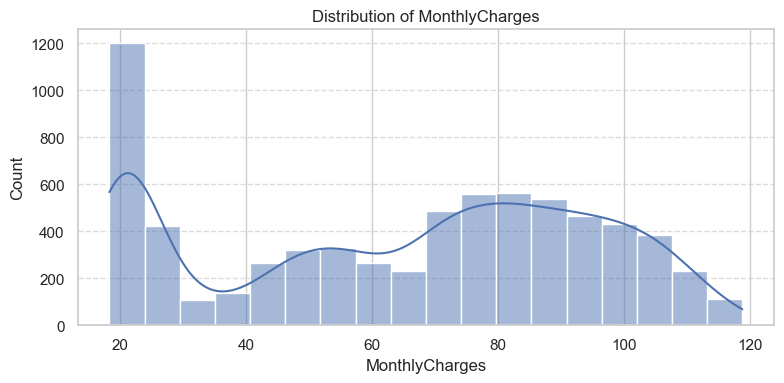

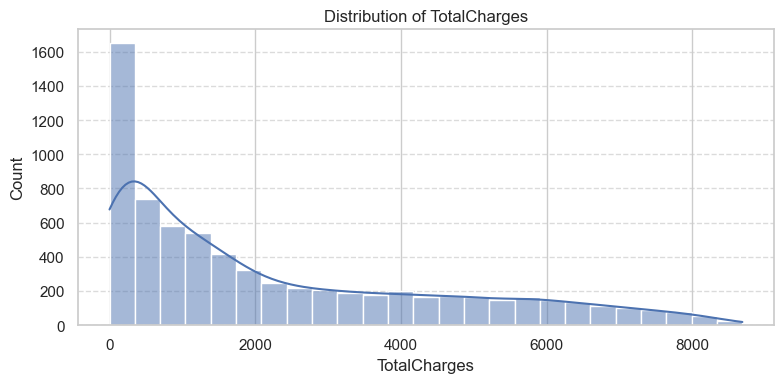

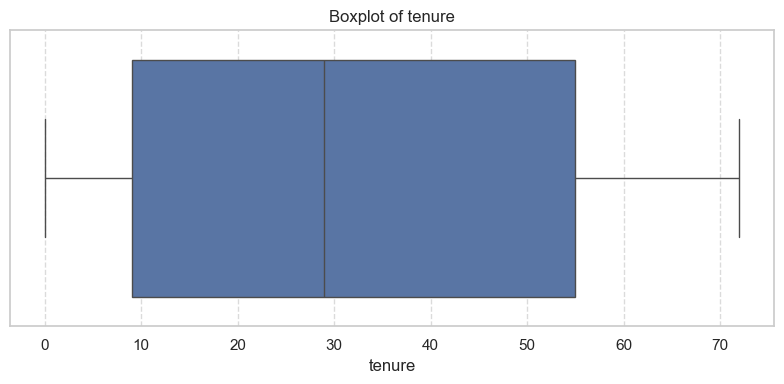

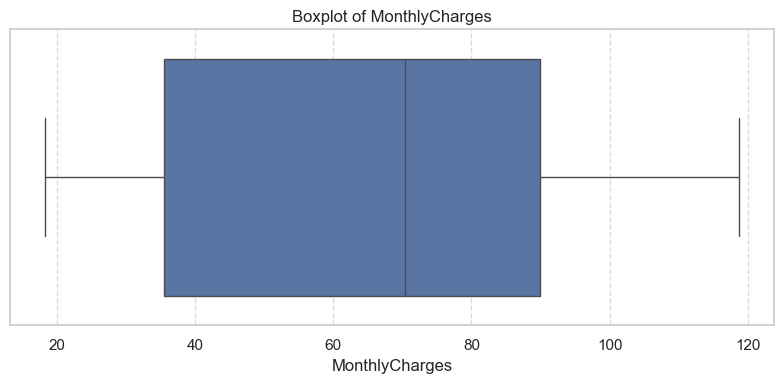

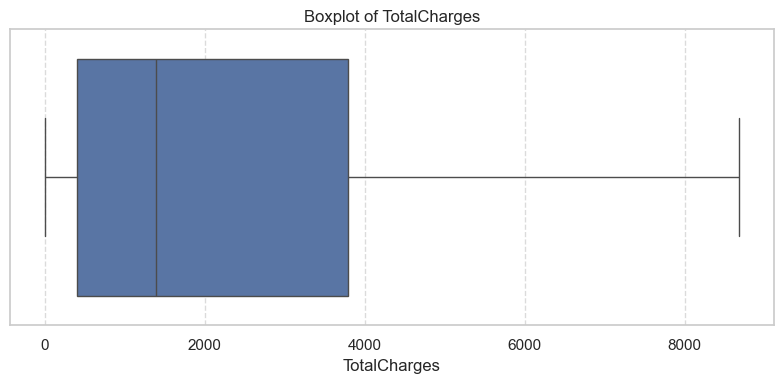

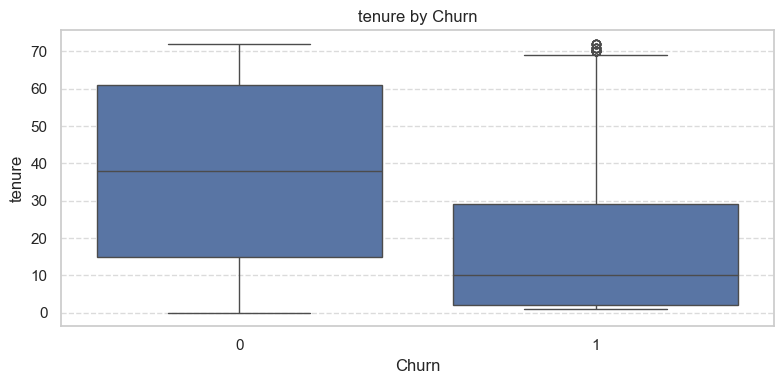

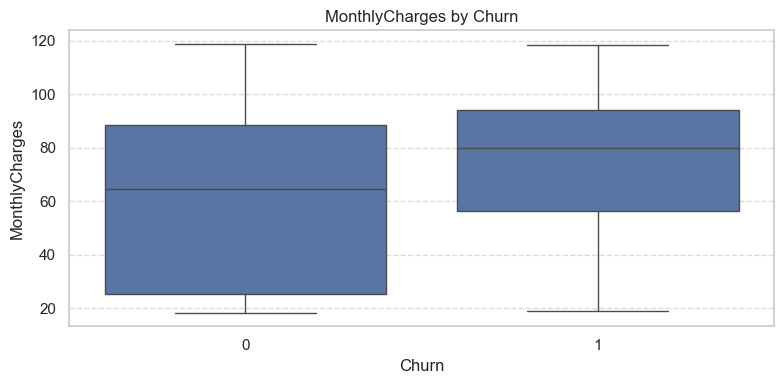

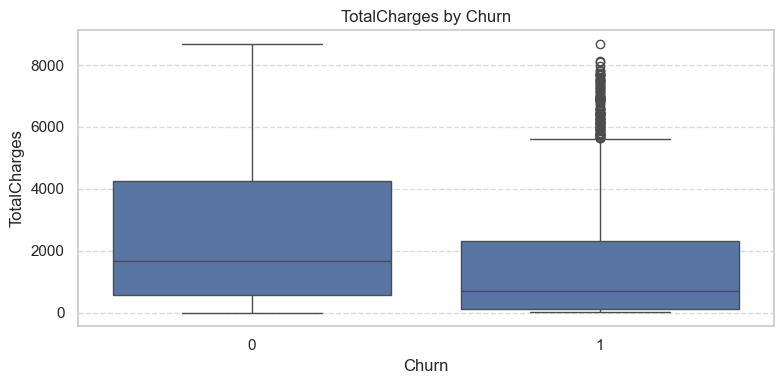

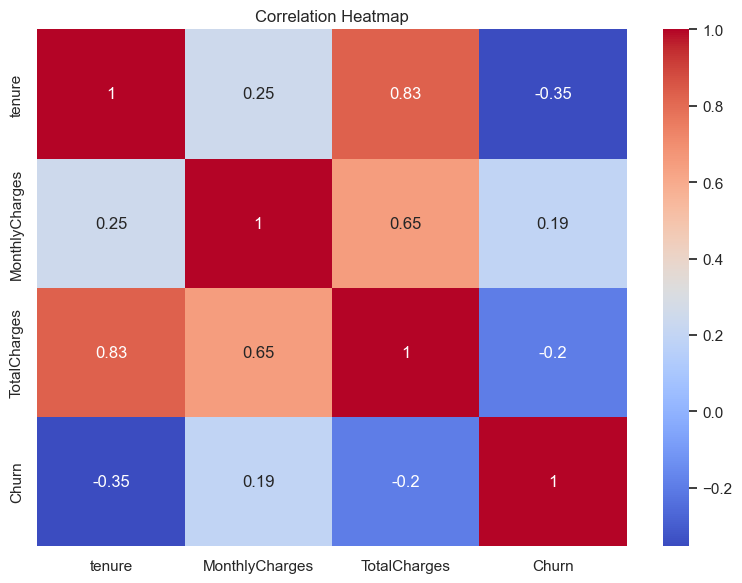

In [123]:
# Set style for better visuals
sns.set_theme(style="whitegrid")

# Numeric distributions
numerics = ['tenure', 'MonthlyCharges', 'TotalCharges']
print(df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

for col in numerics:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Boxplots for outliers
for col in numerics:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Churn vs Numerics
for col in numerics:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='Churn', y=col)
    plt.title(f'{col} by Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    

plt.figure(figsize=(8, 6))
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


Insights:
- Tenure has a u-shape and it shows that there are two main groups: new customers and very old customers. The number of customers significantly drops the middle which suggests that there is a high risk of churn with new customers. Furthermore, it suggests that the customers who survive the period in the middle stay customers for a very long time. 
- Monthly charges show clusters around differently priced plans.
- Total charges are right-skewed which shows that there is a lot of customers that pay smaller amounts of money. The more money is paid the less customers there is.
- Most customers that churn show some of these characteristics: low tenure, high monthly charges, lower total charges (there are some outliers)
- Total charges are highly correlated with tenure and monthly charges

### Categorical data inspection and visualization

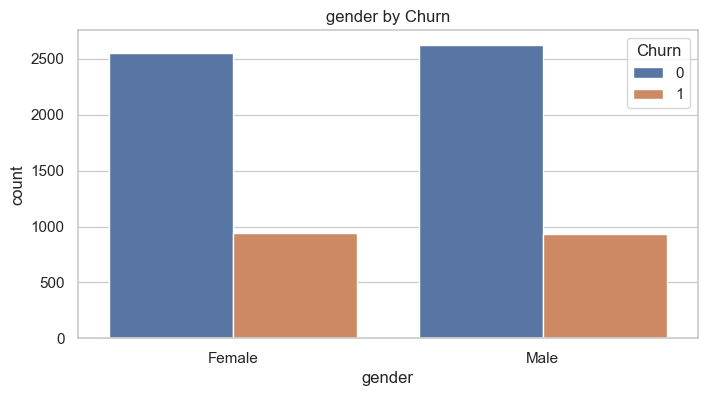

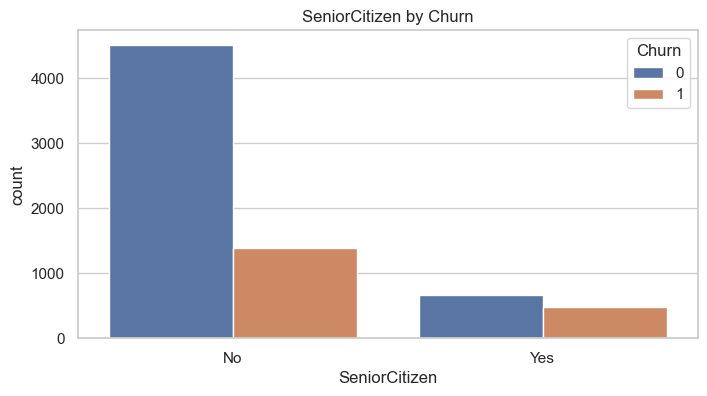

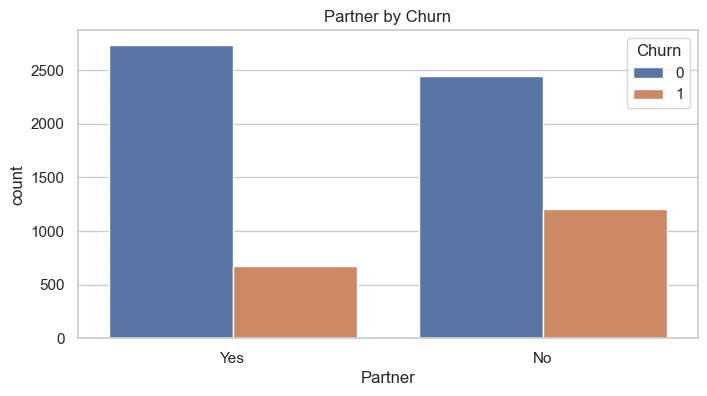

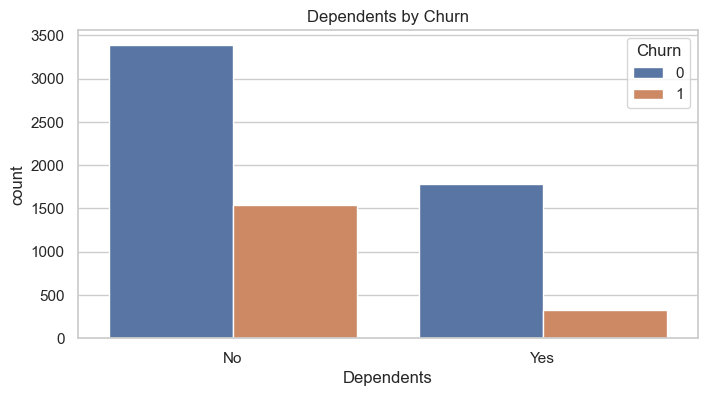

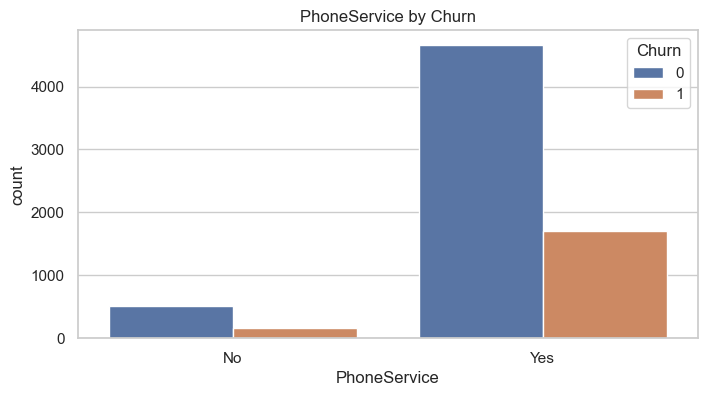

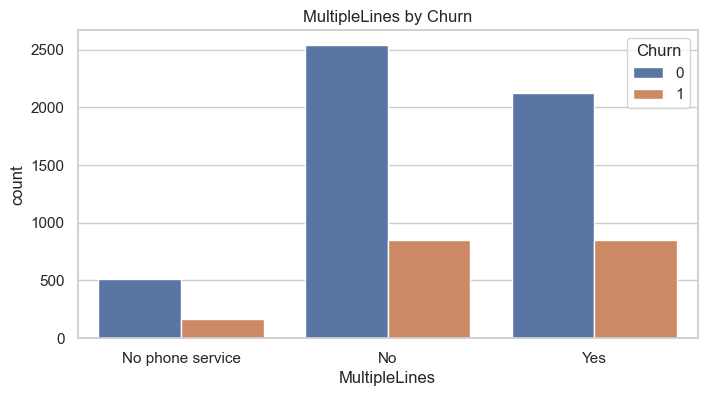

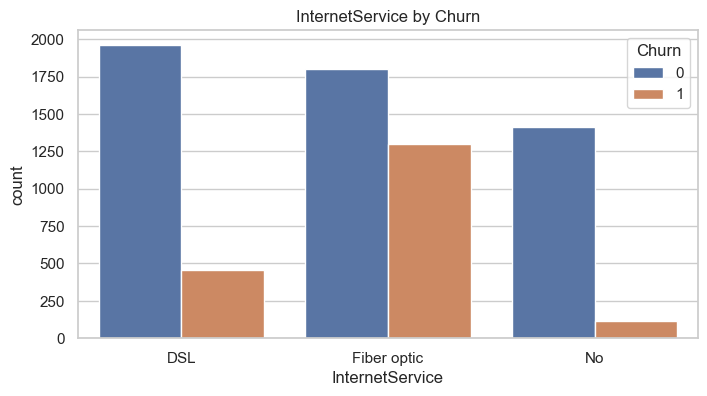

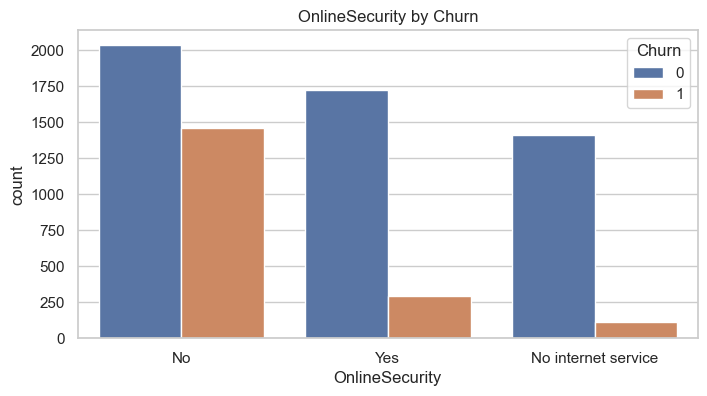

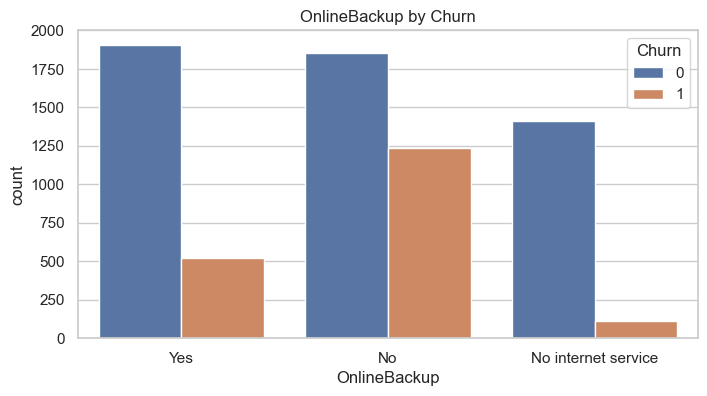

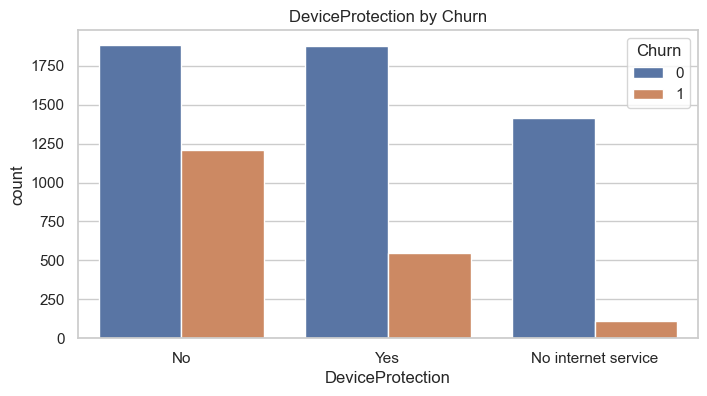

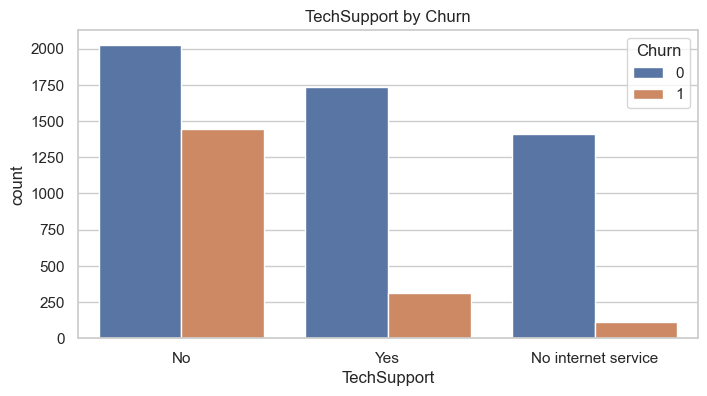

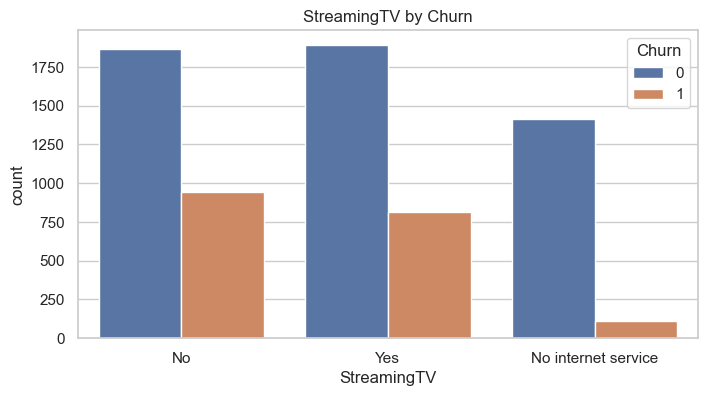

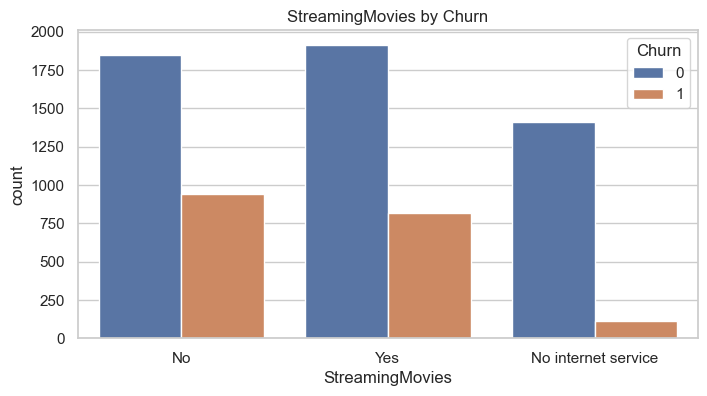

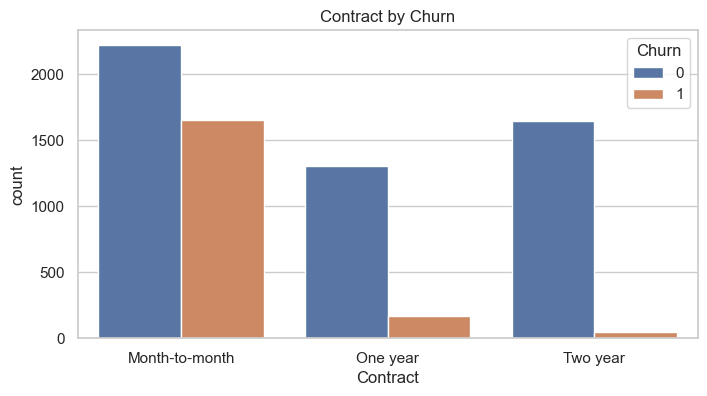

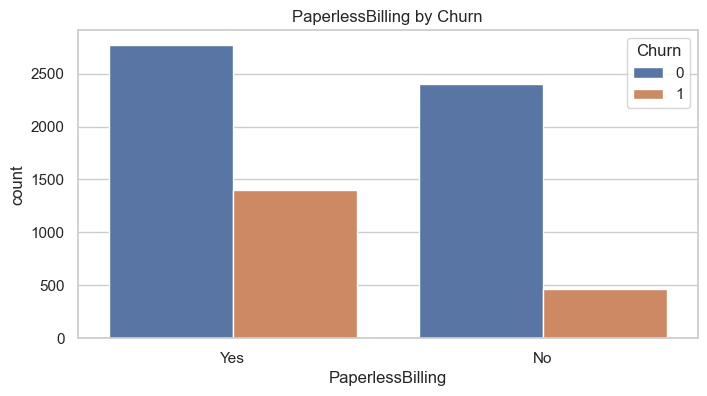

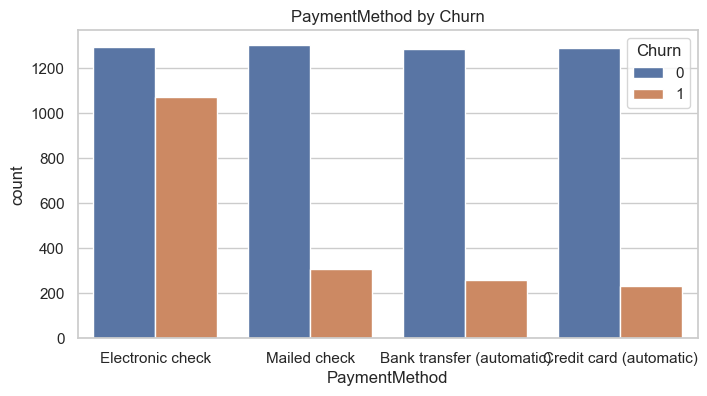

In [124]:
# Identify categorical columns 
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                   'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                   'Contract', 'PaperlessBilling', 'PaymentMethod']

# Churn vs Categoricals
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'{col} by Churn')
    plt.show()

Insights:
- gender is irrelevant for churn prediction
- senior citizens are much more likely to churn then young ones
- customers that don't have a partner are more likely to churn then those who do
- dependants are less likely to churn
- phone service is irrelevant for churn prediction
- multiple lines have very low relevance for churn prediction 
- customers that pay for fiber optic internet service are much more likely to churn
- customers that pay for online security, online backups, device protection or tech support are much less likely to churn then those who don't
- streaming movies or tv has very low relevance for churn prediction
- customers that are on month to month contracts are much more likely to churn then those on yearly contracts
- customers that use paperless billing are more likely to churn then those who don't
- customers that use electronic checks as a payment method are much more likely to churn then those who use any other payment method

In conclusion the features relevant to churn prediction are:
SeniorCitizen, Partner, Dependents, InternetService , OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Contract, PaperlessBilling and PaymentMethod

Other columns should be dropped.

### Removing features that have low relevance for churn prediction

In [125]:
# Remove columns irrelevant for churn prediction
df = df.drop(columns=['PhoneService', 'MultipleLines', 'gender', 'StreamingTV', 'StreamingMovies'])

### Categorical Variables Encoding

In [126]:
# Make a list of columns that are relevant for churn prediction
relevant_categorical_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                             'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=relevant_categorical_cols, drop_first=True)

# Display the new shape and columns
print(f"Data shape after one-hot encoding: {df_encoded.shape}")
print("New columns created:")
print([col for col in df_encoded.columns if col not in df.columns])

Data shape after one-hot encoding: (7043, 24)
New columns created:
['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


### Checking for Multicollinearity (VIF Analysis)

In [127]:
# 1. Prepare the data (Drop Target and ID)
features = df_encoded.drop(['Churn', 'customerID'], axis=1)

# 2. Calculate vif
def vif_calculation(features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features.columns
    vif_values = []
       
    for feature in features.columns:
        # y is the current feature we are testing
        y = features[feature]
        # X is everything else
        X = features.drop(columns=[feature])
            
        # Fit the model
        model = LinearRegression()
        model.fit(X, y)
            
        # Get R-squared
        r_squared = model.score(X, y)
            
        # Calculate VIF: 1 / (1 - R^2)
        # Handling perfect correlation (R^2 = 1) to avoid divide by zero
        if r_squared == 1.0:
            vif = float('inf')
        else:
            vif = 1 / (1 - r_squared)
                
        vif_values.append(vif)
        
    vif_data["VIF"] = vif_values
    return vif_data.sort_values(by="VIF", ascending=False)

print(vif_calculation(features))

                                  Feature        VIF
8      OnlineSecurity_No internet service        inf
14        TechSupport_No internet service        inf
10       OnlineBackup_No internet service        inf
12   DeviceProtection_No internet service        inf
7                      InternetService_No        inf
1                          MonthlyCharges  14.279111
2                            TotalCharges  10.705956
0                                  tenure   7.455283
6             InternetService_Fiber optic   5.478332
17                      Contract_Two year   2.622726
20         PaymentMethod_Electronic check   1.965402
21             PaymentMethod_Mailed check   1.858046
13                   DeviceProtection_Yes   1.627020
15                        TechSupport_Yes   1.616532
16                      Contract_One year   1.611760
19  PaymentMethod_Credit card (automatic)   1.560517
11                       OnlineBackup_Yes   1.500080
9                      OnlineSecurity_Yes   1.

Insights:
- all features that suggest that the customer doesn't have an internet service are totally collinear and therefore they should all, except one, be dropped 
- monthly charges, total charges and tenure are also pretty collinear so at least one of them should be dropped and the one that makes the most sense is total charges because it is just monthly charges multiplied by tenure
- some feature engineering was tested but the new features proved to be very collinear (AvgMonthlySpend and Contract_PaymentMethod) so they were abandoned.

### Dropping highly collinear/unnecessary columns

In [128]:
# List of columns that are multicollinear and therefore unnecessary
cols_to_drop = [
    'OnlineSecurity_No internet service',
    'TechSupport_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'TotalCharges'                        
]

df_encoded = df_encoded.drop(columns=cols_to_drop)
features = df_encoded.drop(['Churn', 'customerID'], axis=1)

print(f"Dropped {len(cols_to_drop)} columns.")
print(f"\nColumns dropped:\n {'\n'.join(cols_to_drop)}")
print("\nFinal collinearity check:\n")
print(vif_calculation(features))

Dropped 5 columns.

Columns dropped:
 OnlineSecurity_No internet service
TechSupport_No internet service
OnlineBackup_No internet service
DeviceProtection_No internet service
TotalCharges

Final collinearity check:

                                  Feature        VIF
1                          MonthlyCharges  11.220834
5             InternetService_Fiber optic   5.465202
6                      InternetService_No   3.596248
0                                  tenure   2.650568
12                      Contract_Two year   2.605751
15         PaymentMethod_Electronic check   1.963880
16             PaymentMethod_Mailed check   1.839280
11                      Contract_One year   1.611707
9                    DeviceProtection_Yes   1.609175
10                        TechSupport_Yes   1.603504
14  PaymentMethod_Credit card (automatic)   1.560146
7                      OnlineSecurity_Yes   1.473712
8                        OnlineBackup_Yes   1.471261
3                             Partner_Yes 

### Data Splitting

In [129]:
# Define features and target
X = df_encoded.drop(['Churn', 'customerID'], axis=1)  # Remove non-numeric columns for SMOTE
y = df_encoded['Churn']

# Split data into train (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Verify the splits
print("Data split sizes:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print("\nChurn rate in each set:")
print(f"Training: {y_train.mean():.2%}")
print(f"Validation: {y_val.mean():.2%}")
print(f"Test: {y_test.mean():.2%}")

Data split sizes:
Training set: 4930 samples
Validation set: 1056 samples
Test set: 1057 samples

Churn rate in each set:
Training: 26.53%
Validation: 26.52%
Test: 26.58%


### Scaling

In [130]:
# Configuring the scaler
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges']

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Verify scaling
print("Scaled numerical features summary:")
print(X_train[num_cols].describe())
print(X_val[num_cols].describe())
print(X_test[num_cols].describe())


Scaled numerical features summary:
             tenure  MonthlyCharges
count  4.930000e+03    4.930000e+03
mean   1.167423e-16    4.143632e-17
std    1.000101e+00    1.000101e+00
min   -1.317619e+00   -1.539324e+00
25%   -9.524160e-01   -9.738588e-01
50%   -1.408545e-01    1.860055e-01
75%    9.547535e-01    8.300071e-01
max    1.604003e+00    1.779062e+00
            tenure  MonthlyCharges
count  1056.000000     1056.000000
mean     -0.033530        0.015213
std       0.983682        0.981149
min      -1.317619       -1.529403
25%      -0.992994       -0.808932
50%      -0.222011        0.191792
75%       0.914175        0.832901
max       1.604003        1.712926
            tenure  MonthlyCharges
count  1057.000000     1057.000000
mean      0.006447       -0.056708
std       0.993302        0.984292
min      -1.317619       -1.544284
25%      -0.952416       -1.026768
50%      -0.100276        0.138883
75%       0.914175        0.787019
max       1.604003        1.714579


### Handling Imbalanced Data: SMOTE Oversampling
The churn rate is imbalanced (~26.5%). To address this, we use SMOTE to oversample the minority class in the training set. This helps the model learn from both classes more effectively.

In [131]:
# Apply SMOTE only to the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("After SMOTE oversampling:")
print(f"Training set size: {X_train_balanced.shape[0]}")
print(f"Churn rate in balanced training set: {y_train_balanced.mean():.2%}")

After SMOTE oversampling:
Training set size: 7244
Churn rate in balanced training set: 50.00%


### Data Leakage Check

In [132]:
### Data Leakage Verification

# Get lists of customerIDs from original data
X_train_ids = df_encoded.loc[X_train.index, 'customerID']
X_val_ids = df_encoded.loc[X_val.index, 'customerID']
X_test_ids = df_encoded.loc[X_test.index, 'customerID']

# Check that customerIDs are properly separated
print("CustomerID overlap check:")
print(f"Train-Val overlap: {len(set(X_train_ids) & set(X_val_ids))}")
print(f"Train-Test overlap: {len(set(X_train_ids) & set(X_test_ids))}")
print(f"Val-Test overlap: {len(set(X_val_ids) & set(X_test_ids))}")

CustomerID overlap check:
Train-Val overlap: 0
Train-Test overlap: 0
Val-Test overlap: 0


### Save Processed Data

In [133]:
# Save the preprocessed data for future use
df_encoded.to_csv('../data/processed/processed_data.csv', index=False)
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_train_balanced.to_csv('../data/processed/X_train_balanced.csv', index=False)
X_val.to_csv('../data/processed/X_val.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False, header=True)
y_train_balanced.to_csv('../data/processed/y_train_balanced.csv', index=False, header=True)
y_val.to_csv('../data/processed/y_val.csv', index=False, header=True)
y_test.to_csv('../data/processed/y_test.csv', index=False, header=True)

print("Processed data saved successfully!")

Processed data saved successfully!
